In [ ]:
!pip install traffic openap

In [1]:
import pandas as pd
from traffic.core import Traffic, Flight
import openap

pd.options.display.max_columns = 100

In [ ]:
# file: eu_flights_2022feb20_filter_resample_meteo.parquet.gz
df_base = pd.read_parquet("https://figshare.com/ndownloader/files/55632065")
t_base = Traffic(df_base)

# file: all_optimized.parquet
df_optimized = pd.read_parquet("https://figshare.com/ndownloader/files/55634282")
t_optimized = Traffic(df_optimized)

# file: grid_era5_smoothed.parquet.gz
df_era5_cost = pd.read_parquet("https://figshare.com/ndownloader/files/55632059")

# file: grid_arpege_smoothed.parquet.gz
df_arpege_cost = pd.read_parquet("https://figshare.com/ndownloader/files/55632062")


In [3]:
t_optimized

,count
flight_id,
ae0224_19259_0,868
06a068_00481_0,653
06a066_00480_0,619
14fa0a_00752_0,619
45ab4e_08279_0,611
7380c0_18273_0,609
502cdf_17655_0,603
461fa1_08600_0,600
461fa0_08596_0,596


In [4]:
sample_flight_ids = t_base.query(
    "timestamp.dt.hour==9 and timestamp.dt.minute==30"
).flight_ids

sample_flight_ids = t_base[sample_flight_ids].longer_than("2h").eval().flight_ids

In [5]:
len(sample_flight_ids)

447

In [6]:
# quickly get the original flight ids for filtering our selected flights
t_optimized = t_optimized.assign(
    base_flight_id=lambda d: d.flight_id.str.replace("_fuel", "")
    .str.replace("_era5_03", "")
    .str.replace("_era5_06", "")
    .str.replace("_arpege_03", "")
    .str.replace("_arpege_06", "")
)

In [7]:
t_optimized_sampled = t_optimized.query(f"base_flight_id.isin({sample_flight_ids})")
t_optimized_sampled

,count
flight_id,
45ab4e_08279_0,611
461fa1_08599_0,575
06a1bc_00603_0,569
06a12d_00578_0,567
06a079_00493_0,565
4bb063_13543_0,553
4acaa2_12019_0,539
502ce6_17668_0,521
424475_06730_0,517


## Visualizing only the flights with persistent contrails

In [8]:
t_optimized_sampled.query("flight_id==base_flight_id").map_leaflet(zoom=4)

Map(center=[44.09029577583392, 9.928988446897108], controls=(ZoomControl(options=['position', 'zoom_in_text', …

plot contrails segments in read over the trajectories

In [9]:
t_optimized_sampled.query("flight_id==base_flight_id").map_leaflet(
    zoom=4,
    highlight={
        "#bd0026": lambda t: t.query("persistent"),
    },
)

Map(center=[44.09029577583392, 9.928988446897108], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Compare with the climate sensitive regions from the ERA5 data

In [10]:
df_era5_cost.query("timestamp.dt.hour==9")

,timestamp,altitude,latitude,longitude,u,v,temperature,specific_humidity,rhi,crit_temp,sac,issr,persistent,height,cost,ts
1029600,2022-02-20 09:00:00+00:00,20000.0,26.0,-15.0,21.031537,-2.952103,250.658207,0.000520,0.480249,239.665230,False,False,False,6096.0,0.000000,32400.0
1029601,2022-02-20 09:00:00+00:00,20000.0,26.0,-14.5,22.253527,-1.069057,250.480499,0.000607,0.569776,239.665230,False,False,False,6096.0,0.000000,32400.0
1029602,2022-02-20 09:00:00+00:00,20000.0,26.0,-14.0,23.360337,0.859970,250.300385,0.000631,0.602949,239.665230,False,False,False,6096.0,0.000000,32400.0
1029603,2022-02-20 09:00:00+00:00,20000.0,26.0,-13.5,24.104481,2.732987,250.307039,0.000594,0.567165,239.665230,False,False,False,6096.0,0.000000,32400.0
1029604,2022-02-20 09:00:00+00:00,20000.0,26.0,-13.0,24.554360,4.581910,250.104113,0.000535,0.521580,239.665230,False,False,False,6096.0,0.000000,32400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143995,2022-02-20 09:00:00+00:00,44000.0,65.5,37.5,18.146716,9.354021,215.988828,0.000003,0.047952,227.860484,True,False,False,13411.2,0.000078,32400.0
1143996,2022-02-20 09:00:00+00:00,44000.0,65.5,38.0,18.587525,9.732664,216.028986,0.000003,0.047688,227.860484,True,False,False,13411.2,0.000067,32400.0
1143997,2022-02-20 09:00:00+00:00,44000.0,65.5,38.5,19.019932,10.168640,216.060455,0.000003,0.047472,227.860484,True,False,False,13411.2,0.000054,32400.0
1143998,2022-02-20 09:00:00+00:00,44000.0,65.5,39.0,19.501968,10.606296,216.113745,0.000003,0.047118,227.860484,True,False,False,13411.2,0.000042,32400.0


In [18]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import BORDERS


def plot_costs_grid(
    df_cost: pd.DataFrame, cmap, select_hour=10, skip_levels=5, ncols=2, nrows=2
):
    proj = ccrs.TransverseMercator(central_longitude=10, central_latitude=50)

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(5 * ncols, 3.5 * nrows), subplot_kw=dict(projection=proj)
    )

    heights = df_cost.height.unique()

    for i, ax in enumerate(axes.flatten()):
        df_cost_pivot = df_cost.query(
            f"ts=={3600 * select_hour} and height=={heights[skip_levels + i]}"
        ).pivot(index="latitude", columns="longitude", values="cost")

        lat, lon, val = (
            df_cost_pivot.index.values,
            df_cost_pivot.columns.values,
            df_cost_pivot.values,
        )

        ax.set_extent([-20, 40, 28, 65])
        ax.add_feature(BORDERS, lw=0.5, edgecolor="gray")
        ax.coastlines(resolution="110m", lw=0.5, color="gray")
        ax.gridlines(
            draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
        )
        ax.contourf(
            lon,
            lat,
            val,
            cmap=cmap,
            alpha=0.8,
            transform=ccrs.PlateCarree(),
            vmin=-df_cost.cost.quantile(0.01),
            vmax=df_cost.cost.quantile(0.99),
        )

        fl = heights[skip_levels + i] / openap.aero.ft // 1000 * 10

        ax.text(0.03, 0.9, f"FL{int(fl)}", transform=ax.transAxes, fontsize=20)

    plt.tight_layout()
    return plt


<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

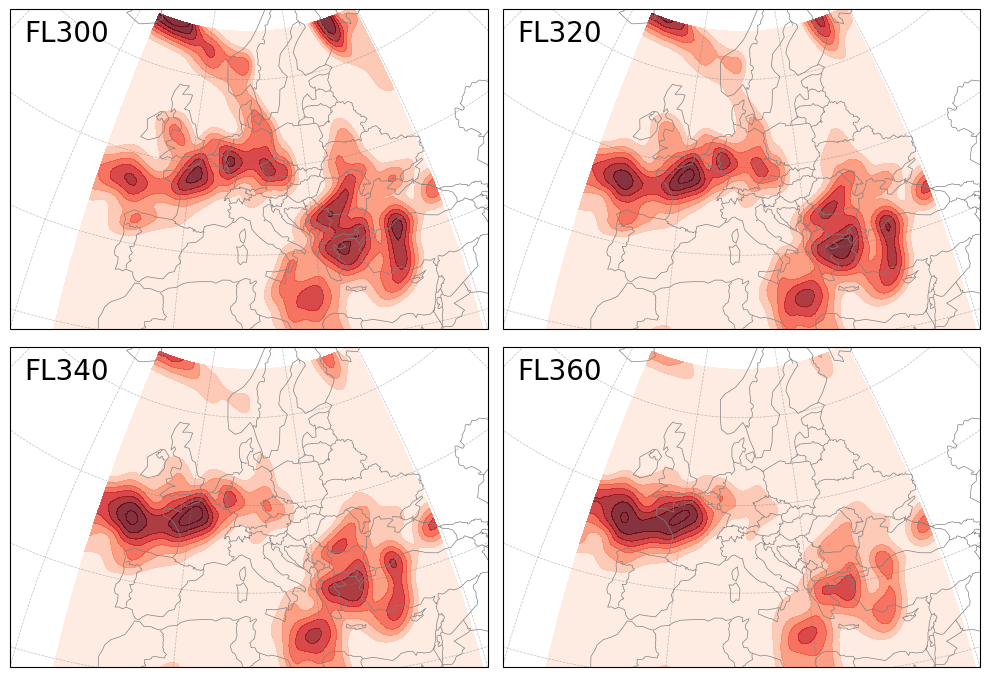

In [19]:
plot_costs_grid(df_era5_cost, select_hour=9, cmap="Reds")

## How does the forecast data look like when dealing with persistent contrails?

<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

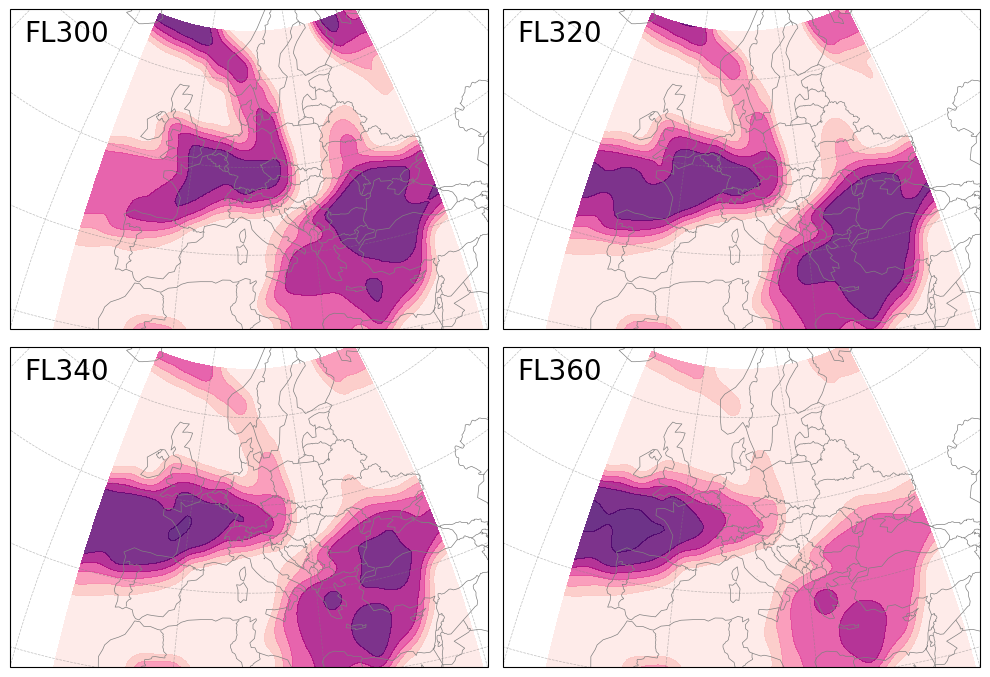

In [20]:
plot_costs_grid(df_arpege_cost, select_hour=9, cmap="RdPu")